In [1]:
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from random import shuffle
import numpy as np
import os
from PIL import Image
from torchvision import transforms
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.utils.data as data_utils

In [2]:
data_path = "data/data_first_25"

In [3]:
test_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop center square of 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])
    ])

In [4]:
def get_img_list(cat,d1):
    ret = list()
    image_paths = list()
    for frame in os.listdir(data_path + '/{}/{}'.format(cat,d1)):
        img_pil = Image.open(data_path + '/{}/{}/{}'.format(cat,d1,frame))
        input_img = test_transform(img_pil)
        ret.append(input_img)
        image_paths.append(data_path + '/{}/{}/{}'.format(cat,d1,frame))
    return ret, image_paths

# This sets the first 7 videos as val and the rest as train, which are the official train/test splits for UCF101
# https://www.crcv.ucf.edu/data/UCF101.php
def createTrainAndValSet(categories):
    category_options = sorted(os.listdir(data_path))
    category_names = category_options[:categories]
    train_set = []
    val_set = []
    train_image_paths = []
    val_image_paths = []
    
    i=0
    for cat in category_names:
        print(cat)
        for d1 in os.listdir(data_path + '/{}'.format(cat)):
            img_list, image_paths = get_img_list(cat,d1)
            if int(d1[1:3]) >= 8:
                train_set.append((img_list,i))
                train_image_paths.append(image_paths)
            else:
                val_set.append((img_list,i))
                val_image_paths.append(image_paths)
        i+=1
    print("train_len", len(train_set), "val_len", len(val_set))
    return train_set,val_set, train_image_paths, val_image_paths

In [5]:
class AverageModel(nn.Module):
    def __init__(self, output_size=5, batchSize=3):
        super(AverageModel, self).__init__()

        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.output_size = output_size
        self.batchSize = batchSize
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, output_size)
        
    def forward(self, x_3d):
        result = torch.zeros((batchSize,self.output_size)).cuda()
        for frame in range(x_3d.size(1)):
            x = self.resnet(x_3d[:, frame, :, :, :])  # ResNet
            x = x.view(x.size(0), -1)             # flatten output of conv

            # FC layers
            x = self.fc1(x)
          
            result += x
        result /= x_3d.size(1)
        return result

In [6]:
# No longer used, using DataLoader instead of this
def load_data(dataset, batchSize, shuffle_data=True):
    train_loader = []
    i = 0
    if shuffle_data:
        shuffle(dataset)
    while i + batchSize < len(dataset):
        batch_inputs = []
        batch_labels = []
        for j in range(batchSize):
            batch_inputs.append(torch.stack(dataset[i + j][0]))
            batch_labels.append(torch.tensor([dataset[i + j][1]]))
        
        batch_inputs = torch.stack(batch_inputs)
        batch_labels = torch.stack(batch_labels).squeeze()
        train_loader.append((batch_inputs, batch_labels))
        i += batchSize
    return train_loader

In [7]:
from random import shuffle

train_accuracies = []; train_losses = [];
val_accuracies = []; val_losses = [];

def train_model(model, loss_fn, optimizer, batchSize, epochs):
    model = model.cuda()
    loss_fn = loss_fn.cuda()
    
    train_loader = DataLoader(train_set, batch_size=batchSize, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batchSize, drop_last=True, shuffle=True)
    
    print("training...")
    for epoch in range(epochs):
        correct = 0
        cum_loss = 0

        model.train()
        for (i, (inputs, target)) in enumerate(train_loader):
            frame_list = torch.stack(inputs).transpose(0, 1).cuda()
            
            scores = model(frame_list)            
            loss = loss_fn(scores, torch.tensor(np.array(target),dtype=torch.long).cuda())

            target = target.cuda()
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == target).sum().item()
            cum_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i + 1) % 40 == 0:
                print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

        train_accuracies.append(correct / ((i + 1) * batchSize))
        train_losses.append(cum_loss / (i + 1))   
        
        correct = 0
        cum_loss = 0
        model.eval()
        for (i, (inputs, target)) in enumerate(val_loader):
            frame_list = torch.stack(inputs).transpose(0, 1).cuda()

            scores = model(frame_list)
            loss = loss_fn(scores, torch.tensor(np.array(target),dtype=torch.long).cuda())

            target = target.cuda()
            max_scores, max_labels = scores.max(1)
            correct += (max_labels == target).sum().item()
            cum_loss += loss.item()
            
        print('Validation-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
               (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))
        
        val_accuracies.append(correct / ((i + 1) * batchSize))
        val_losses.append(cum_loss / (i + 1))

In [8]:
categories = 10

train_set, val_set, train_image_paths, val_image_paths = createTrainAndValSet(categories)

ApplyEyeMakeup
ApplyLipstick
Archery
BabyCrawling
BalanceBeam
BandMarching
BaseballPitch
Basketball
BasketballDunk
BenchPress
train_len 985 val_len 389


In [9]:
learning_rate = 5e-4
momentum = 0.5
weight_decay = 1e-4
batchSize= 20
epochs = 25

my_model = AverageModel(output_size=categories, batchSize=batchSize)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

train_model(my_model, loss_fn, optimizer, batchSize, epochs)

training...
Train-epoch 0. Iteration 00040, Avg-Loss: 2.1698, Accuracy: 0.2487
Validation-epoch 0. Iteration 00019, Avg-Loss: 1.9072, Accuracy: 0.4263
Train-epoch 1. Iteration 00040, Avg-Loss: 1.7484, Accuracy: 0.6262
Validation-epoch 1. Iteration 00019, Avg-Loss: 1.5774, Accuracy: 0.6158
Train-epoch 2. Iteration 00040, Avg-Loss: 1.4298, Accuracy: 0.7863
Validation-epoch 2. Iteration 00019, Avg-Loss: 1.3262, Accuracy: 0.7737
Train-epoch 3. Iteration 00040, Avg-Loss: 1.1806, Accuracy: 0.8662
Validation-epoch 3. Iteration 00019, Avg-Loss: 1.1299, Accuracy: 0.7895
Train-epoch 4. Iteration 00040, Avg-Loss: 0.9866, Accuracy: 0.9038
Validation-epoch 4. Iteration 00019, Avg-Loss: 0.9815, Accuracy: 0.8711
Train-epoch 5. Iteration 00040, Avg-Loss: 0.8267, Accuracy: 0.9450
Validation-epoch 5. Iteration 00019, Avg-Loss: 0.8569, Accuracy: 0.8421
Train-epoch 6. Iteration 00040, Avg-Loss: 0.7194, Accuracy: 0.9463
Validation-epoch 6. Iteration 00019, Avg-Loss: 0.7959, Accuracy: 0.8763
Train-epoch 7. 

Data: 10 non-consecutive frames, equally separated throughout video
Categories: 10
Model: Average
Loss Function: CrossEntropyLoss
Optimizer: SGD
Learning Rate: 0.0005
Momentum: 0.5
Weight Decay: 0.0001
Batch Size: 20


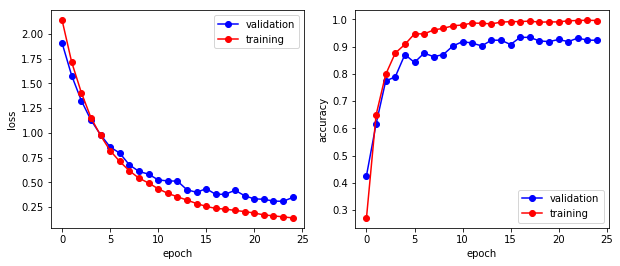

In [10]:
print("Data: 10 non-consecutive frames, equally separated throughout video")
print("Categories:", categories)
print("Model: Average")
print("Loss Function: CrossEntropyLoss")
print("Optimizer: SGD")
print("Learning Rate:", learning_rate)
print("Momentum:", momentum)
print("Weight Decay:", weight_decay)
print("Batch Size:", batchSize)

plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_losses, 'bo-', label = 'val-loss')
plt.plot(train_losses, 'ro-', label = 'train-loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'bo-', label = 'val-acc')
plt.plot(train_accuracies, 'ro-', label = 'train-acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'training'], loc='lower right')
plt.show()

In [11]:
my_model.eval()

AverageModel(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [12]:
# Code adapted from: https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes).cuda()
with torch.no_grad():
    for inputs, classes in val_set:
        inputs = torch.stack(inputs).unsqueeze(0)

        frame_list = inputs.cuda()
        classes = torch.tensor([classes]).cuda()
        outputs = my_model(frame_list)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


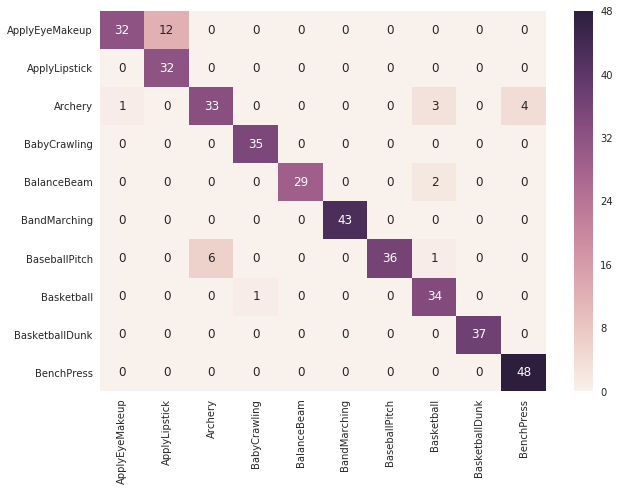

In [13]:
# Code adapted from: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix.cpu().numpy()
category_names = ["ApplyEyeMakeup","ApplyLipstick","Archery","BabyCrawling","BalanceBeam","BandMarching","BaseballPitch","Basketball","BasketballDunk","BenchPress"] 
# ,"Biking","Billiards","BlowDryHair","BlowingCandles","BodyWeightSquats","Bowling","BoxingPunchingBag","BoxingSpeedBag","BreastStroke","BrushingTeeth","CleanAndJerk","CliffDiving","CricketBowling","CricketShot","CuttingInKitchen","Diving","Drumming","Fencing","FieldHockeyPenalty","FloorGymnastics","FrisbeeCatch","FrontCrawl","GolfSwing","Haircut","HammerThrow","Hammering","HandstandPushups","HandstandWalking","HeadMassage","HighJump","HorseRace","HorseRiding","HulaHoop","IceDancing","JavelinThrow","JugglingBalls","JumpRope","JumpingJack","Kayaking","Knitting"]
df_cm = pd.DataFrame(array, index = [i for i in category_names],
                  columns = [i for i in category_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


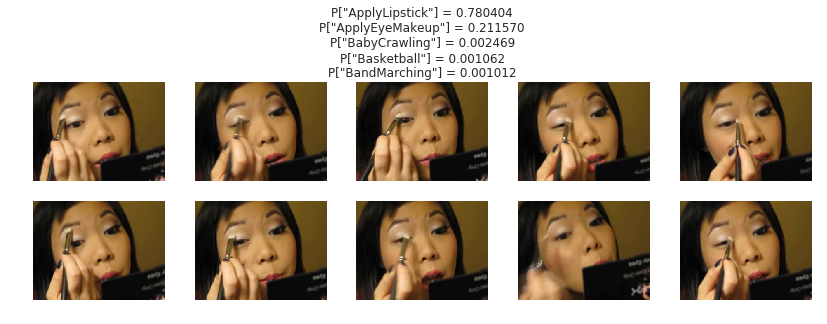

In [101]:
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import display
to_img = ToPILImage()
from PIL import Image

category_names = ["ApplyEyeMakeup","ApplyLipstick","Archery","BabyCrawling","BalanceBeam","BandMarching","BaseballPitch","Basketball","BasketballDunk","BenchPress"] 
# Using code from Assignment 4: https://colab.research.google.com/drive/1Xz5JkOajDs9RdxlzZiLv5WP9Rb-hDCRS#scrollTo=Khg2L3QgC1lI
def display_result(predictions, classes, image_index):
    probs, indices = (-F.softmax(predictions, dim = 1).data).sort()
    probs = (-probs).cpu().numpy()[0][:5]; indices = indices.cpu().numpy()[0][:10]
    preds = ['P[\"' + classes[idx] + '\"] = ' + ('%.6f' % prob) \
         for (prob, idx) in zip(probs, indices)]
    
#   Adapted code from here to display grid of images: https://stackoverflow.com/questions/36006136/how-to-display-images-in-a-row-with-ipython-display
    fig = plt.figure(figsize = (14,4))
    plt.title('\n'.join(preds));plt.grid(False); plt.axis('off');
    number_of_files = 10
    for i in range(number_of_files):
        a=fig.add_subplot(2,number_of_files//2,i+1)
        image = plt.imread(val_image_paths[image_index][i])
        plt.imshow(image,cmap='Greys_r')
        plt.axis('off')
    plt.show()

def show_scores(index):
    test_set = [val_set[index]]
    with torch.no_grad():
        for inputs, classes in test_set:
            inputs = torch.stack(inputs).unsqueeze(0)
            frame_list = inputs.cuda()
            classes = torch.tensor([classes]).cuda()
            outputs = my_model(frame_list)
            _, preds = torch.max(outputs, 1)
            display_result(outputs, category_names, index)
            
            
# Select index within the val_set (0-388 if using 10 categories)
index = 26
show_scores(index)